# Goal
This notebook seeks to answer the question: what is the expected value of a speeding ticket? We assume that speeding saves you time, which is worth money. But you have a small chance of getting caught, which wastes both time and money. So when is it worth it to speed?

# Conclusion
It usually makes sense to speed a bit above the limit, especially when you do it just a bit. But this model assumes a fairly high cost of a speeding ticket, and a fairly low risk of getting caught. A slight change to these factors would change the model a lot, making it inaccurate.

# Get the speeding data for Ontario from a file

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fine_dict = dict()
demerit_dict = dict()
with open("speeding_data.csv") as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        speed = int(row[0])
        fine_dict[speed] = float(row[1][1:])
        demerit_dict[speed] = int(row[2])

# Build the model
## Part 1: cost functions
Speeding has both costs and benefits. The main benefit is saving time. If you go at speed $\Delta v$ (at a speed limit $v$) for a distance $d$, then you save $ d/v - d/(v+\Delta v)$ minutes of time. If you value time at rate $s$, then speeding has a constant benefit of $ sd \left( 1/v - 1/(v+\Delta v) \right)$

On the other hand, speeding has a cost. Assuming you pay the cost of the ticket, that is of course one cost. However, you may have increased insurance rates, and demerit points, which are harder to value. 
- This [source](http://www.mdia2003.org/2013/for-sale-three-demerit-points-rrp-1000/) (admittedly not super legitimate seeming) says demerit points for for \$500 to \$1000, but for Australia. For simplicity, I will say demerit points are worth \$200 each.
- This [source](https://www.theglobeandmail.com/globe-drive/culture/commuting/is-it-worth-it-to-fight-my-speeding-ticket-in-court/article23970625/) says that a speeding ticket might increase your insurance rates by \$300 per year. Let's assume that getting a ticket (any ticket) increases your insurance rates at \$300 real dollars per year (working in real dollars avoids dealing with interest). Tickets stay on your records for 3 years in Ontario (same source as above), so this brings the total cost to \$900.

In [3]:
def get_speeding_benefit_function(speed_limit, distance, value_of_time):
    """
    Speed is in km/h, distance is in km, value of time is $/hr
    """
    def speeding_benefit_function(speed_over_limit):
        return value_of_time * distance * \
            (1. / speed_limit - 1. / (speed_limit + speed_over_limit))
    
    return speeding_benefit_function

def get_speeding_cost_function(insurance_cost=900, demerit_pt_cost=200):
    def speeding_cost_function(speed_over_limit):
        if speed_over_limit <= 0:
            return 0
        return insurance_cost + fine_dict[speed_over_limit] + demerit_pt_cost * demerit_dict[speed_over_limit]
    return speeding_cost_function

### Test the functions

In [4]:
get_speeding_benefit_function(100, 100, 1)(50)

0.3333333333333333

In [5]:
get_speeding_cost_function()(40)

1995.0

## Part 2: risk of getting caught
Most people don't get caught when they speed, but if you do it enough it is almost certain that you will get caught. It is probably best to describe the risk in "risk per km"

This risk is very hard to gauge. Not finding any easy data, I would estimate that the risk increases as you speed more. So my back of the envelope calculation is this:
- Most people in Ontario go 10-20 over the limit regularly, and don't get caught much (say once every 5 years)
- Assume that the average person in Onario travells 16 000 km per year (see figure 6 in [this report](http://oee.nrcan.gc.ca/publications/statistics/cvs08/chapter2.cfm?attr=0)) This puts the risk at 1.25e-5 / km.
- Assume that the risk doubles at every 10 km interval. I don't really have a good basis for this

In [6]:
def speeding_risk(speed_over_limit):
    base_rate = 1.25e-5
    if speed_over_limit <= 0:
        return 0.
    if 0 <= speed_over_limit <= 20:
        return base_rate
    if 20 <= speed_over_limit <= 30:
        return 2 * base_rate
    if 30 <= speed_over_limit <= 40:
        return 4 * base_rate
    if 40 <= speed_over_limit <= 50:
        return 8 * base_rate
    raise ValueError("Model not defined for over 50!")

# Now we can calculate the expected value of speeding

In [7]:
def expected_value_of_speeding_per_km(amount_of_speeding, speed_limit, distance, value_of_time):
    benefit_function = get_speeding_benefit_function(speed_limit, distance, value_of_time)
    cost_function = get_speeding_cost_function()
    
    # Note if you speed, you still get the time benefit if you are caught
    # So I don't subtract the risk value
    return benefit_function(amount_of_speeding) - \
        distance * (speeding_risk(amount_of_speeding) * 
                    cost_function(amount_of_speeding))

In [8]:
# Function for plotting
def speed_plot(*args):
    x = range(50)
    y = [expected_value_of_speeding_per_km(v, *args) for v in x]
    plt.title(r"{} km per day, speed limit {}, time ${}/hour".format(*args))
    plt.plot(x, y)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.show()

# Go through a few situations
You commute 50 km per day, with an average speed limit of 80. You value your time at \$20 per hour

Worth it to speed a bit, but not a huge amount (this amounts to dollars per day)

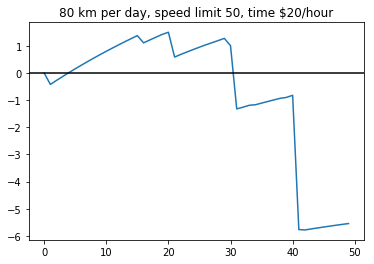

In [9]:
speed_plot(80, 50, 20)

You do a LOT of city driving (200 km per day), average speed 50 km per hour. You value your time at \$20 per hour.

In this case, speeding is definitely worth it

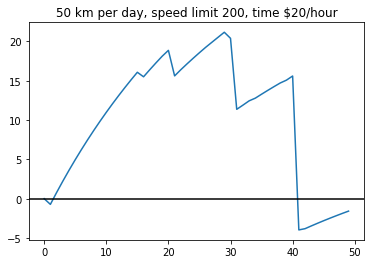

In [10]:
speed_plot(50, 200, 20)

You do a lot of highway driving (200 km per day), and you value your time a lot (\$40/hour)

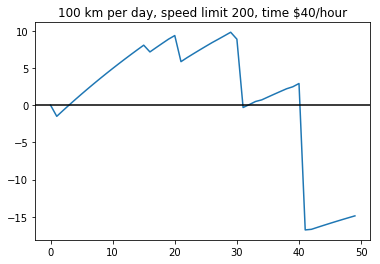

In [11]:
speed_plot(100, 200, 40)